# Vsh striplog from log

This notebooks looks at the main `striplog` object. For the basic objects it depends on, see [Basic objects](./Basic_objects.ipynb).

First, import anything we might need.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import striplog
striplog.__version__

'0.7.1'

In [2]:
from striplog import Legend, Component, Striplog

<hr />


## Striplogs from logs

We can read a log from an LAS file with `welly`:

In [3]:
from welly import Well

In [4]:
w = Well.from_las("data/las/P-129_out.LAS")
gr = w.data['GR']

Next we make a list of components to pass into the new striplog. The order must match the values you pass in the `to_log()` function:

In [5]:
comps = [Component({'lithology': 'sandstone'}),
         Component({'lithology': 'greywacke'}),
         Component({'lithology': 'shale'}), ]

In [6]:
legend_csv = """colour, width, component lithology
#FFF057, 3, Sandstone
#A9ABAE, 2, Greywacke
#BBBBBB, 1, Shale
"""
legend = Legend.from_csv(legend_csv)

Make a striplog from the GR curve, using the cutoffs given as `cutoff = [10, 50]`. These cutoffs define 3 lithologies, whichi is what we're passing in as `comps`. There must be enough components for the intervals you're defining.

If you don't provide `components`, you can provide `legend` instead; the components will be drawn from that. If you pass 'too many' components, they will be used in order and the 'extra' ones ignored.

You have to pass in the depth/elevation basis as well, because no assumptions are made about the log's extent.

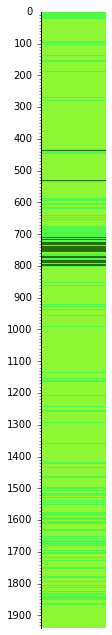

In [7]:
s = Striplog.from_log(gr, cutoff=[10, 50], components=comps, basis=gr.basis)
s.plot(aspect=6)

Now we can, say, remove the thin beds:

In [8]:
s.prune(limit=5)
s.anneal()
s

Striplog(78 Intervals, start=1.0668, stop=1939.1376000000012)

<hr />
## Add data from the log to the intervals

And then read the log back into the intervals, 'reducing' with a function if we want:

In [10]:
import numpy as np
s.extract(gr, basis=gr.basis, name='GR', function=np.mean)

In [11]:
s[20]

Interval({'base': Position({'units': 'm', 'middle': 674.6748000000003}), 'description': '', 'components': [Component({'lithology': 'shale'})], 'top': Position({'units': 'm', 'middle': 647.8524000000002}), 'data': {'GR': 82.240132789964392}})

<hr />
## Go back from striplog to log

Now close the loop by exporting these values as a new log and comparing to the original. Since we reduced with `np.mean`, we will get a blocked log...

In [12]:
g, gz, _ = s.to_log(field="GR", return_meta=True)

In [24]:
from welly import Curve
blocky = Curve(g, basis=gz, params={'mnemonic': 'GR_block', 'units': 'gAPI'})

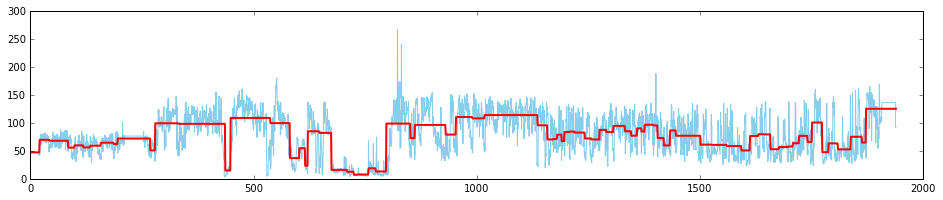

In [13]:
plt.figure(figsize=(16,3))
plt.plot(gr.basis, gr, color='skyblue')
plt.plot(gz, g, lw=2, color='red')
plt.show()

## With a log transformation

In [14]:
def vsh(clean, shale):
    """
    Returns a function that computes mean VSH in the interval
    [0, 1], given GR values for clean sand and typical shale.
    """
    def _vsh(gr):
        mean = np.mean((gr - clean) / (shale - clean))
        return max(0.0, min(1.0, mean))
    return _vsh

In [15]:
s.extract(gr, basis=gr.basis, name='VSH', function=vsh(20, 80))

In [16]:
s[20]

Interval({'base': Position({'units': 'm', 'middle': 674.6748000000003}), 'description': '', 'components': [Component({'lithology': 'shale'})], 'top': Position({'units': 'm', 'middle': 647.8524000000002}), 'data': {'VSH': 1.0, 'GR': 82.240132789964392}})

<hr />

## Plot everything

We could add everything to the well and plot it that way:

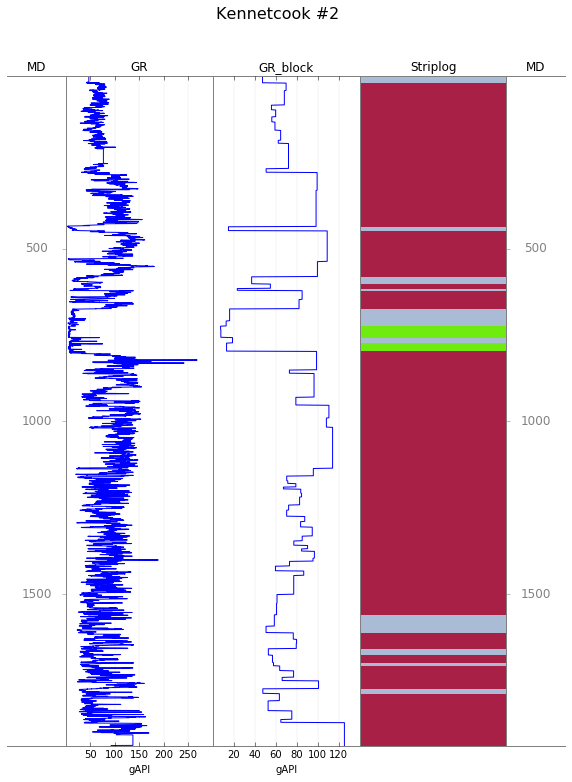

In [28]:
w.data['GR_block'] = blocky
w.data['Striplog'] = s
w.plot(tracks=['MD', 'GR', 'GR_block', 'Striplog', 'MD'])

But we have more control if we plot the elements separately. Also, this is currently the only way to make use of the colour plotting style for striplogs:

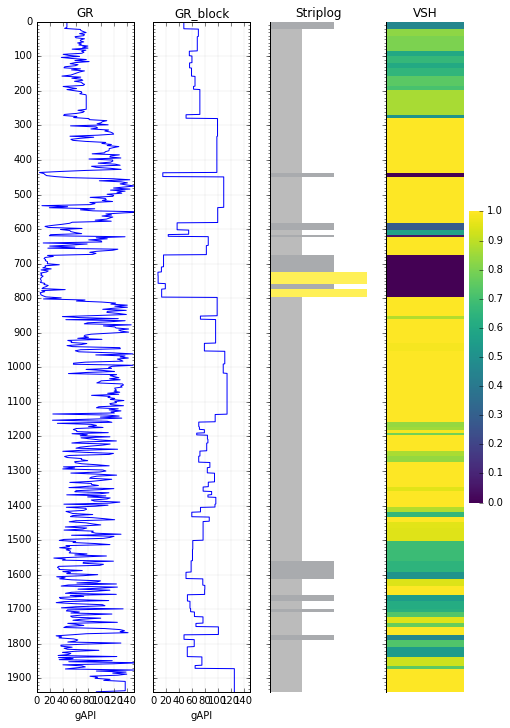

In [25]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True, figsize=(8,12))

ax0 = gr.despike().to_basis(step=3).plot(ax=ax0)
ax1 = blocky.plot(ax=ax1)
ax2 = s.plot(ax=ax2, legend=legend)
ax3 = s.plot(ax=ax3, colour='VSH')

ax0.set_xlim(0, 150); ax1.set_xlim(0, 150)
ax2.set_title('Striplog')
ax3.set_title('VSH')

plt.show()

<hr />

<p style="color:gray">©2015 Agile Geoscience. Licensed CC-BY. <a href="https://github.com/agile-geoscience/striplog">striplog.py</a></p>